In [208]:
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas._libs.tslibs.parsing import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import get_data
import os
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

In [209]:
file_path = os.path.join(os.getcwd(), 'dataset')

In [210]:
dataset = get_data.GetData().get_day_purchase()
dataset.to_csv(file_path+"/day_purchase.csv")

/Users/Jackie/Desktop/mum-time/projects/ml/cashflow_prediction/get_data.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



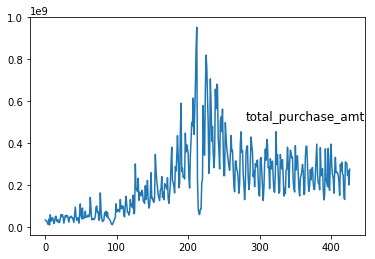

In [211]:
# load dataset
dataset = read_csv(file_path+"/day_purchase.csv", header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [212]:
# Use MinMaxScaler to normalize Weighted Price to range from 0 to 1
values = dataset['total_purchase_amt'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [213]:
# Split 70% of data for training and 30% for testing
train_size = 392
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

392 35


In [214]:
# Create function for creating dataset with look back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back - 1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [215]:
# Generate dataset for trainX, trainY, testX, testY
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

387
30


In [216]:
# Reshape X for model training
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [217]:
# Running the LSTM model with 300 epochs
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
keras.optimizers.SGD(lr=0.6, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

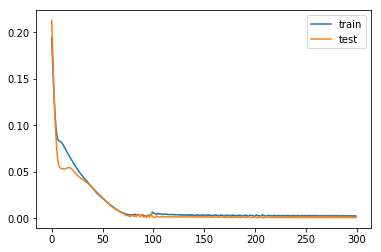

In [218]:
# Plot line graph to show amount loss according the the epoch
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

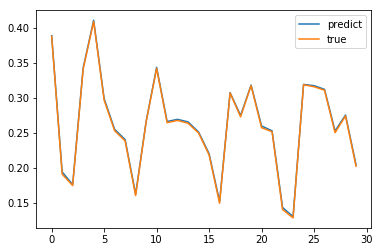

In [219]:
# Make prediction using textX and plotting line graph against testY
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [221]:
# Scaler Inverse Y back to normal value
# calculate rmse
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1701023.896


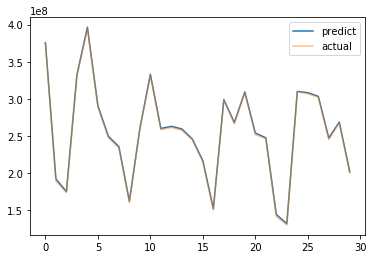

In [222]:
# Plot line graph with Y as RMB
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [223]:
# Convert X to dates
predictDates = dataset.tail(len(testX)).index

In [224]:
# Reshape testY and yhat for plotly
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [225]:
# Plot predicted and actual line graph with X=dates, Y=RMB
# actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
# predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')

# py.iplot([predict_chart, actual_chart])

In [226]:
testY_reshape_scale = testY_reshape - 10000000
yhat_reshape_scale = yhat_reshape

In [227]:
# Plot predicted and actual line graph with X=dates, Y=RMB
actual_chart = go.Scatter(x=predictDates, y=testY_reshape_scale, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape_scale, name= 'Predict Price')

py.iplot([predict_chart, actual_chart])